# Data Analysis 101 - DuckDB

Alex Chen

Source:

https://github.com/allisonhorst/palmerpenguins/tree/main

https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081

---

在此教學中，我們會利用一公開資料集來進行基礎的資料分析。這個資料集是一個關於三種企鵝的觀察資料。

本文共分為九個段落，分別對應到資料處理過程中常見的九種情境。透過這份教學，預期你可以學會如何在 Python 中操作強大的資料庫系統 `duckdb` 進行資料處理，以解決常見的實務問題。

接下來，就開始我們的資料分析之旅！

![Penguins](https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/lter_penguins.png?raw=true)

Artwork by @allison_horst

首先，我們需要匯入此專案中需要的套件：

* `duckdb`: 資料庫
* `pandas`: 內含 Python 常見的資料表型態
* `matplotlib`: 資料視覺化
* `seaborn`: 資料視覺化（進階）

在下方程式碼中，`as` 是用來幫套件取別稱。如此一來，在接下來的程式碼中，若需要用到套件時，就不需要輸入全名，例如需要用到 `pandas` 時，只需要輸入 `pd` 就可以了。

In [1]:
%matplotlib inline
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

下方程式碼是如果需要在視覺化中加入中文時，需要使用的額外控制。

In [2]:
import matplotlib.font_manager as fm
fm.fontManager.addfont('../Supplements/NotoSansTC-VariableFont_wght.ttf')
plt.rcParams['font.sans-serif'] =  ['Noto Sans TC']
plt.rcParams['axes.unicode_minus']=False # 用來正常顯示負號

基本上，DuckDB 的指令都與 SQL 指令相同，只是在 Python 的環境使用時，需要透過 `duckdb.sql()` 來進行呼叫，執行這些指令。SQL 語法相當直覺，隨著課程進行，你將會認識更多不同的語法。

# 1. 讀入資料

在進行資料分析前，最一開始一定要把資料讀取到執行環境中，才可以發揮套件的功能。`duckdb` 支援所有常見的資料格式，包括 `.csv`, `.xlsx` 等。

我們可以將資料利用 `CREATE TABLE` 的語法存入 `duckdb` 的資料庫內，方便我們進行後續分析。

其中 `CREATE OR REPLACE TABLE df1 AS` 代表如果 `df1` 這張表不存在的話，就直接依照後列規則創建這張表，但如果已經存在，則直接覆蓋。而 `SELECT * FROM 'penguins_info.csv'` 代表從 `penguins_info.csv` 這張表中選取所有的欄位。`*` 代表「所有」的意思。`SELECT` 後面會接需要回傳的欄位，而 `FROM` 會接表的名稱。

注意引號的差異：在 Python 中，若是單行的內容，使用單引號 (`'`) 或雙引號 (`"`) 都是可以的。若是多行的內容，則需使用三個雙引號 (`"""`) 包括住指令。

In [3]:
duckdb.sql("""
           INSTALL spatial;
           LOAD spatial;
           """) # 支援 Excel

In [4]:
duckdb.sql("""
           CREATE OR REPLACE TABLE df1 AS
           SELECT * FROM '../Tutorial_Data/penguins_info.csv';
           """)

In [5]:
duckdb.sql("""
           CREATE OR REPLACE TABLE df2 AS
           SELECT * FROM st_read('../Tutorial_Data/penguins_measurements.xlsx');
           """) # 匯入 Excel 檔案

In [6]:
duckdb.sql('SHOW ALL TABLES;') # 顯示資料表

┌──────────┬─────────┬─────────┬─────────────────────────────────────────────────────────────────────────────────┬─────────────────────────────────────────────┬───────────┐
│ database │ schema  │  name   │                                  column_names                                   │                column_types                 │ temporary │
│ varchar  │ varchar │ varchar │                                    varchar[]                                    │                  varchar[]                  │  boolean  │
├──────────┼─────────┼─────────┼─────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────┼───────────┤
│ memory   │ main    │ df1     │ [ID, Species, Island, Sex]                                                      │ [BIGINT, VARCHAR, VARCHAR, VARCHAR]         │ false     │
│ memory   │ main    │ df2     │ [ID, Culmen Length (mm), Culmen Depth (mm), Flipper Length (mm), Body Mass (g)] │ [INTEGER, DOUBLE, DO

# 2. 資料概覽

讀入資料後，我們來看一看讀入的資料究竟長什麼樣子，以及藉由一些語法，帶我們了解資料集的樣態。

基本的 SQL 指令如下：

```sql
SELECT 要選取的欄位
FROM 資料表
WHERE 條件
GROUP BY 聚合欄位
HAVING 聚合後條件
ORDER BY 排序欄位
LIMIT 限制顯示數目;
```

In [7]:
duckdb.sql("""
           SELECT * 
           FROM df1;
           """) # 顯示 df1 資料表

┌───────┬────────────────┬───────────┬─────────┐
│  ID   │    Species     │  Island   │   Sex   │
│ int64 │    varchar     │  varchar  │ varchar │
├───────┼────────────────┼───────────┼─────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     4 │ Adelie Penguin │ Torgersen │ NULL    │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     6 │ Adelie Penguin │ Torgersen │ MALE    │
│     7 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     8 │ Adelie Penguin │ Torgersen │ MALE    │
│     9 │ Adelie Penguin │ Torgersen │ NULL    │
│    10 │ Adelie Penguin │ Torgersen │ NULL    │
│     · │       ·        │   ·       │  ·      │
│     · │       ·        │   ·       │  ·      │
│     · │       ·        │   ·       │  ·      │
│   335 │ Gentoo Penguin │ Biscoe    │ FEMALE  │
│   336 │ Gentoo Penguin │ Biscoe    │ MALE    │
│   337 │ Gentoo Penguin │ Biscoe    │ .       │
│   338 │ Gentoo Pen

In [8]:
duckdb.sql('SELECT * FROM df1 LIMIT 5;') # 顯示 df1 前 5 筆資料

┌───────┬────────────────┬───────────┬─────────┐
│  ID   │    Species     │  Island   │   Sex   │
│ int64 │    varchar     │  varchar  │ varchar │
├───────┼────────────────┼───────────┼─────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     4 │ Adelie Penguin │ Torgersen │ NULL    │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │
└───────┴────────────────┴───────────┴─────────┘

In [9]:
duckdb.sql("""
           SELECT COUNT(*) AS 筆數
           FROM df1;
           """) # 計算 df1 資料表筆數

┌───────┐
│ 筆數  │
│ int64 │
├───────┤
│   344 │
└───────┘

In [10]:
duckdb.sql("""
           SELECT COUNT(*) AS 欄數
           FROM INFORMATION_SCHEMA.COLUMNS
           WHERE TABLE_NAME = 'df1';
           """) # 計算 df1 資料表欄數

┌───────┐
│ 欄數  │
│ int64 │
├───────┤
│     4 │
└───────┘

In [11]:
duckdb.sql("""
           SELECT column_name AS 欄位名稱
           FROM INFORMATION_SCHEMA.COLUMNS
           WHERE TABLE_NAME = 'df1';
           """) # 顯示 df1 資料表欄位名稱

┌──────────┐
│ 欄位名稱 │
│ varchar  │
├──────────┤
│ ID       │
│ Species  │
│ Island   │
│ Sex      │
└──────────┘

In [12]:
duckdb.sql("""
           SELECT column_name, data_type AS 資料型態
           FROM INFORMATION_SCHEMA.COLUMNS
           WHERE TABLE_NAME = 'df1';
           """) # 顯示 df1 的資料型態

┌─────────────┬──────────┐
│ column_name │ 資料型態 │
│   varchar   │ varchar  │
├─────────────┼──────────┤
│ ID          │ BIGINT   │
│ Species     │ VARCHAR  │
│ Island      │ VARCHAR  │
│ Sex         │ VARCHAR  │
└─────────────┴──────────┘

In [13]:
duckdb.sql("""
           SELECT Species, COUNT(Species) AS 數量
           FROM df1
           GROUP BY Species;
           """) # 類別型資料的計數

┌───────────────────┬───────┐
│      Species      │ 數量  │
│      varchar      │ int64 │
├───────────────────┼───────┤
│ Gentoo Penguin    │   124 │
│ Adelie Penguin    │   152 │
│ Chinstrap Penguin │    68 │
└───────────────────┴───────┘

In [14]:
duckdb.sql("""
           SELECT * 
           FROM df2 
           LIMIT 5;
           """)

┌───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     1 │               39.1 │              18.7 │                 181 │          3750 │
│     2 │               39.5 │              17.4 │                 186 │          3800 │
│     3 │               40.3 │              18.0 │                 195 │          3250 │
│     4 │               NULL │              NULL │                NULL │          NULL │
│     5 │               36.7 │              19.3 │                 193 │          3450 │
└───────┴────────────────────┴───────────────────┴─────────────────────┴───────────────┘

![Culmen](https://github.com/allisonhorst/palmerpenguins/blob/main/man/figures/culmen_depth.png?raw=true)

In [15]:
duckdb.sql("""
           SELECT column_name, data_type AS 資料型態 
           FROM INFORMATION_SCHEMA.COLUMNS 
           WHERE TABLE_NAME = 'df2';
           """)

┌─────────────────────┬──────────┐
│     column_name     │ 資料型態 │
│       varchar       │ varchar  │
├─────────────────────┼──────────┤
│ ID                  │ INTEGER  │
│ Culmen Length (mm)  │ DOUBLE   │
│ Culmen Depth (mm)   │ DOUBLE   │
│ Flipper Length (mm) │ INTEGER  │
│ Body Mass (g)       │ INTEGER  │
└─────────────────────┴──────────┘

In [16]:
duckdb.sql("""
           SELECT MIN("Body Mass (g)")
           FROM df2;
           """) # 最小值

┌──────────────────────┐
│ min("Body Mass (g)") │
│        int32         │
├──────────────────────┤
│                 2700 │
└──────────────────────┘

In [17]:
duckdb.sql("""
           SELECT MAX("Body Mass (g)")
           FROM df2;
           """) # 最大值

┌──────────────────────┐
│ max("Body Mass (g)") │
│        int32         │
├──────────────────────┤
│                 6300 │
└──────────────────────┘

In [18]:
duckdb.sql("""
           SELECT AVG("Body Mass (g)")
           FROM df2;
           """) # 平均值

┌──────────────────────┐
│ avg("Body Mass (g)") │
│        double        │
├──────────────────────┤
│    4201.754385964912 │
└──────────────────────┘

In [19]:
duckdb.sql("""
           SELECT STDDEV("Body Mass (g)")
           FROM df2;
           """) # 標準差

┌─────────────────────────┐
│ stddev("Body Mass (g)") │
│         double          │
├─────────────────────────┤
│       801.9545356980948 │
└─────────────────────────┘

In [20]:
duckdb.sql("""
           SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY "Body Mass (g)") AS 中位數
           FROM df2;
           """) # 中位數

┌────────┐
│ 中位數 │
│ double │
├────────┤
│ 4050.0 │
└────────┘

# 3. 資料搜索

對資料有粗淺的了解後，我們可以利用一些語法搜索特定資料，將焦點放在我們感興趣的資料上。

In [21]:
duckdb.sql("""
           SELECT "Culmen Depth (mm)", "Culmen Length (mm)"
           FROM df2;
           """) # 選取欄位

┌───────────────────┬────────────────────┐
│ Culmen Depth (mm) │ Culmen Length (mm) │
│      double       │       double       │
├───────────────────┼────────────────────┤
│              18.7 │               39.1 │
│              17.4 │               39.5 │
│              18.0 │               40.3 │
│              NULL │               NULL │
│              19.3 │               36.7 │
│              20.6 │               39.3 │
│              17.8 │               38.9 │
│              19.6 │               39.2 │
│              18.1 │               34.1 │
│              20.2 │               42.0 │
│                ·  │                 ·  │
│                ·  │                 ·  │
│                ·  │                 ·  │
│              14.1 │               46.2 │
│              16.0 │               55.1 │
│              15.7 │               44.5 │
│              16.2 │               48.8 │
│              13.7 │               47.2 │
│              NULL │               NULL │
│          

In [22]:
duckdb.sql("""
           SELECT #3, #2
           FROM df2;
           """) # 用欄位編號選取欄位

┌───────────────────┬────────────────────┐
│ Culmen Depth (mm) │ Culmen Length (mm) │
│      double       │       double       │
├───────────────────┼────────────────────┤
│              18.7 │               39.1 │
│              17.4 │               39.5 │
│              18.0 │               40.3 │
│              NULL │               NULL │
│              19.3 │               36.7 │
│              20.6 │               39.3 │
│              17.8 │               38.9 │
│              19.6 │               39.2 │
│              18.1 │               34.1 │
│              20.2 │               42.0 │
│                ·  │                 ·  │
│                ·  │                 ·  │
│                ·  │                 ·  │
│              14.1 │               46.2 │
│              16.0 │               55.1 │
│              15.7 │               44.5 │
│              16.2 │               48.8 │
│              13.7 │               47.2 │
│              NULL │               NULL │
│          

需注意的是，在 SQL 語法中選取特定第 N 筆資料是較為複雜的操作。在 SQL 中通常是用條件進行選取。

In [23]:
duckdb.sql("""
           SELECT "Culmen Depth (mm)", "Body Mass (g)"
           FROM df2
           WHERE "Body Mass (g)" >= 6000;
           """)

┌───────────────────┬───────────────┐
│ Culmen Depth (mm) │ Body Mass (g) │
│      double       │     int32     │
├───────────────────┼───────────────┤
│              15.2 │          6300 │
│              17.0 │          6050 │
│              16.3 │          6000 │
│              16.2 │          6000 │
└───────────────────┴───────────────┘

常見的條件運算符包含：`=`（等於）, `>`（大於）, `<`（小於）, `>=`（大於等於）, `<=`（小於等於）, `<>`（不等於）。

# 4. 資料清理與修改

選取資料後，會發現資料中有需要調整的地方，例如某些值有誤，或者是某些欄位不需要，也有可能是有缺失值（ N/A 值）需要移除。接下來我們來看看 `duckdb` 如何處理這些情況。

In [24]:
duckdb.sql("""
           CREATE OR REPLACE TABLE df_temp AS
           SELECT *
           FROM df2;
           """) # 複製一張表

In [25]:
duckdb.sql("""
           ALTER TABLE df_temp
           DROP "Culmen Length (mm)";
           """) # 刪除欄位，一次只能刪除一個

duckdb.sql("""
           ALTER TABLE df_temp
           DROP "Culmen Depth (mm)";
           """)

In [26]:
duckdb.sql("""
           SELECT *
           FROM df_temp
           """)

┌───────┬─────────────────────┬───────────────┐
│  ID   │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │        int32        │     int32     │
├───────┼─────────────────────┼───────────────┤
│     1 │                 181 │          3750 │
│     2 │                 186 │          3800 │
│     3 │                 195 │          3250 │
│     4 │                NULL │          NULL │
│     5 │                 193 │          3450 │
│     6 │                 190 │          3650 │
│     7 │                 181 │          3625 │
│     8 │                 195 │          4675 │
│     9 │                 193 │          3475 │
│    10 │                 190 │          4250 │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│   335 │                 217 │          4375 │
│   336 │                 230 │          5850 │
│   337 │                 217 │          4875 │
│   338 │                 222 │         

In [27]:
duckdb.sql("""
           UPDATE df_temp
           SET ID = 1, "Flipper Length (mm)" = 181, "Body Mass (g)" = 3750
           WHERE ID = 2
           """) # 修改特定列與欄的資料

In [28]:
duckdb.sql("""
           SELECT *
           FROM df_temp
           """)

┌───────┬─────────────────────┬───────────────┐
│  ID   │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │        int32        │     int32     │
├───────┼─────────────────────┼───────────────┤
│     1 │                 181 │          3750 │
│     1 │                 181 │          3750 │
│     3 │                 195 │          3250 │
│     4 │                NULL │          NULL │
│     5 │                 193 │          3450 │
│     6 │                 190 │          3650 │
│     7 │                 181 │          3625 │
│     8 │                 195 │          4675 │
│     9 │                 193 │          3475 │
│    10 │                 190 │          4250 │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│   335 │                 217 │          4375 │
│   336 │                 230 │          5850 │
│   337 │                 217 │          4875 │
│   338 │                 222 │         

In [29]:
duckdb.sql("""
           SELECT *, COUNT(*) AS 重複次數
           FROM df_temp
           GROUP BY *
           HAVING 重複次數 > 1
           """) # 計算重複的列數

┌───────┬─────────────────────┬───────────────┬──────────┐
│  ID   │ Flipper Length (mm) │ Body Mass (g) │ 重複次數 │
│ int32 │        int32        │     int32     │  int64   │
├───────┼─────────────────────┼───────────────┼──────────┤
│     1 │                 181 │          3750 │        2 │
└───────┴─────────────────────┴───────────────┴──────────┘

In [30]:
duckdb.sql("""
           SELECT DISTINCT *
           FROM df_temp
           ORDER BY ID;
           """) # 刪除重複的列

┌───────┬─────────────────────┬───────────────┐
│  ID   │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │        int32        │     int32     │
├───────┼─────────────────────┼───────────────┤
│     1 │                 181 │          3750 │
│     3 │                 195 │          3250 │
│     4 │                NULL │          NULL │
│     5 │                 193 │          3450 │
│     6 │                 190 │          3650 │
│     7 │                 181 │          3625 │
│     8 │                 195 │          4675 │
│     9 │                 193 │          3475 │
│    10 │                 190 │          4250 │
│    11 │                 186 │          3300 │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│     · │                  ·  │            ·  │
│   335 │                 217 │          4375 │
│   336 │                 230 │          5850 │
│   337 │                 217 │          4875 │
│   338 │                 222 │         

In [31]:
duckdb.sql("""
           SELECT 
            COUNT (*) - COUNT(ID) AS ID_NA_Count,
            COUNT (*) - COUNT("Culmen Length (mm)") AS Culmen_Length_NA_Count,
            COUNT (*) - COUNT("Culmen Depth (mm)") AS Culmen_Depth_NA_Count,
            COUNT (*) - COUNT("Flipper Length (mm)") AS Flipper_Length_NA_Count,
            COUNT (*) - COUNT("Body Mass (g)") AS Body_Mass_NA_Count
           FROM df2;
           """) # 欄位遺失值的計數

┌─────────────┬────────────────────────┬───────────────────────┬─────────────────────────┬────────────────────┐
│ ID_NA_Count │ Culmen_Length_NA_Count │ Culmen_Depth_NA_Count │ Flipper_Length_NA_Count │ Body_Mass_NA_Count │
│    int64    │         int64          │         int64         │          int64          │       int64        │
├─────────────┼────────────────────────┼───────────────────────┼─────────────────────────┼────────────────────┤
│           0 │                      2 │                     2 │                       2 │                  2 │
└─────────────┴────────────────────────┴───────────────────────┴─────────────────────────┴────────────────────┘

In [32]:
duckdb.sql("""
           SELECT *
           FROM df2
           WHERE ID IS NULL
            OR "Culmen Length (mm)" IS NULL
            OR "Culmen Depth (mm)" IS NULL
            OR "Flipper Length (mm)" IS NULL
            OR "Body Mass (g)" IS NULL;
           """) # 取得有遺失值的列

┌───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     4 │               NULL │              NULL │                NULL │          NULL │
│   340 │               NULL │              NULL │                NULL │          NULL │
└───────┴────────────────────┴───────────────────┴─────────────────────┴───────────────┘

In [33]:
duckdb.sql("""
           DELETE FROM df2
           WHERE ID IS NULL
            OR "Culmen Length (mm)" IS NULL
            OR "Culmen Depth (mm)" IS NULL
            OR "Flipper Length (mm)" IS NULL
            OR "Body Mass (g)" IS NULL;
           """) # 刪除遺失值

In [34]:
duckdb.sql("""
           SELECT *
           FROM df2
           WHERE ID IS NULL
            OR "Culmen Length (mm)" IS NULL
            OR "Culmen Depth (mm)" IS NULL
            OR "Flipper Length (mm)" IS NULL
            OR "Body Mass (g)" IS NULL;
           """)

┌───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │       double       │      double       │        int32        │     int32     │
├───────┴────────────────────┴───────────────────┴─────────────────────┴───────────────┤
│                                        0 rows                                        │
└──────────────────────────────────────────────────────────────────────────────────────┘

In [35]:
duckdb.sql("""
           SELECT 
            COUNT (*) - COUNT(ID) AS ID_NA_Count,
            COUNT (*) - COUNT(Species) AS Species_NA_Count,
            COUNT (*) - COUNT(Island) AS Island_NA_Count,
            COUNT (*) - COUNT(Sex) AS Sex_NA_Count
           FROM df1;
           """) # 欄位遺失值的計數

┌─────────────┬──────────────────┬─────────────────┬──────────────┐
│ ID_NA_Count │ Species_NA_Count │ Island_NA_Count │ Sex_NA_Count │
│    int64    │      int64       │      int64      │    int64     │
├─────────────┼──────────────────┼─────────────────┼──────────────┤
│           0 │                0 │               0 │           10 │
└─────────────┴──────────────────┴─────────────────┴──────────────┘

In [36]:
duckdb.sql("""
           DELETE FROM df1
           WHERE ID IS NULL
            OR Species IS NULL
            OR Island IS NULL
            OR Sex IS NULL;
           """)

In [37]:
duckdb.sql("""
           SELECT *
           FROM df1
           WHERE ID IS NULL
            OR Species IS NULL
            OR Island IS NULL
            OR Sex IS NULL;
           """)

┌───────┬─────────┬─────────┬─────────┐
│  ID   │ Species │ Island  │   Sex   │
│ int64 │ varchar │ varchar │ varchar │
├───────┴─────────┴─────────┴─────────┤
│               0 rows                │
└─────────────────────────────────────┘

In [38]:
duckdb.sql("""
           SELECT Sex, COUNT(*)
           FROM df1
           GROUP BY Sex;
           """)

┌─────────┬──────────────┐
│   Sex   │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ MALE    │          168 │
│ FEMALE  │          165 │
│ .       │            1 │
└─────────┴──────────────┘

In [39]:
duckdb.sql("""
           SELECT *
           FROM df1
           WHERE Sex = '.';
           """)

┌───────┬────────────────┬─────────┬─────────┐
│  ID   │    Species     │ Island  │   Sex   │
│ int64 │    varchar     │ varchar │ varchar │
├───────┼────────────────┼─────────┼─────────┤
│   337 │ Gentoo Penguin │ Biscoe  │ .       │
└───────┴────────────────┴─────────┴─────────┘

In [40]:
duckdb.sql("""
           DELETE FROM df1
           WHERE Sex = '.';
           """) # 刪除特定條件的列

In [41]:
duckdb.sql("""
           SELECT Sex, COUNT(*)
           FROM df1
           GROUP BY Sex;
           """)

┌─────────┬──────────────┐
│   Sex   │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ FEMALE  │          165 │
│ MALE    │          168 │
└─────────┴──────────────┘

# 5. 資料合併

有時候，合併資料才能發揮其價值，那要如何合併呢？最重要的有兩個關鍵：選定合併的鍵值（要根據哪個欄位來進行資料合併）以及合併方式（以誰為主要的合併參考對象）。決定好後，剩下的就交給 `duckdb`。

![join](https://realpython.com/cdn-cgi/image/width=811,format=auto/https://files.realpython.com/media/join_diagram.93e6ef63afbe.png)

Image from https://realpython.com/pandas-merge-join-and-concat/

In [42]:
duckdb.sql("""
           SELECT *
           FROM df1;
           """)

┌───────┬────────────────┬───────────┬─────────┐
│  ID   │    Species     │  Island   │   Sex   │
│ int64 │    varchar     │  varchar  │ varchar │
├───────┼────────────────┼───────────┼─────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     6 │ Adelie Penguin │ Torgersen │ MALE    │
│     7 │ Adelie Penguin │ Torgersen │ FEMALE  │
│     8 │ Adelie Penguin │ Torgersen │ MALE    │
│    13 │ Adelie Penguin │ Torgersen │ FEMALE  │
│    14 │ Adelie Penguin │ Torgersen │ MALE    │
│    15 │ Adelie Penguin │ Torgersen │ MALE    │
│     · │       ·        │   ·       │  ·      │
│     · │       ·        │   ·       │  ·      │
│     · │       ·        │   ·       │  ·      │
│   333 │ Gentoo Penguin │ Biscoe    │ FEMALE  │
│   334 │ Gentoo Penguin │ Biscoe    │ MALE    │
│   335 │ Gentoo Penguin │ Biscoe    │ FEMALE  │
│   336 │ Gentoo Pen

In [43]:
duckdb.sql("""
           SELECT *
           FROM df2;
           """)

┌───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     1 │               39.1 │              18.7 │                 181 │          3750 │
│     2 │               39.5 │              17.4 │                 186 │          3800 │
│     3 │               40.3 │              18.0 │                 195 │          3250 │
│     5 │               36.7 │              19.3 │                 193 │          3450 │
│     6 │               39.3 │              20.6 │                 190 │          3650 │
│     7 │               38.9 │              17.8 │                 181 │          3625 │
│     8 │               39.2 │              19.6 │                 195 │          4675 │
│     9 │            

In [44]:
duckdb.sql("""
           CREATE OR REPLACE TABLE df AS
           SELECT *
           FROM df1 INNER JOIN df2
           ON df1.ID = df2.ID
           """) # 透過 ID 欄位合併兩個資料集，指定為 inner join

In [45]:
duckdb.sql("""
           SELECT *
           FROM df
           """)

┌───────┬────────────────┬───────────┬─────────┬───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │    Species     │  Island   │   Sex   │ ID_1  │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int64 │    varchar     │  varchar  │ varchar │ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────┼───────────┼─────────┼───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │     1 │               39.1 │              18.7 │                 181 │          3750 │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │     2 │               39.5 │              17.4 │                 186 │          3800 │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │     3 │               40.3 │              18.0 │                 195 │          3250 │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │

In [46]:
duckdb.sql("""
           CREATE OR REPLACE TABLE df_right AS
           SELECT *
           FROM df1 RIGHT JOIN df2
           ON df1.ID = df2.ID
           """) # 透過 ID 欄位合併兩個資料集，指定為 right join

In [47]:
duckdb.sql("""
           SELECT *
           FROM df_right
           """)

┌───────┬────────────────┬───────────┬─────────┬───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │    Species     │  Island   │   Sex   │ ID_1  │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int64 │    varchar     │  varchar  │ varchar │ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────┼───────────┼─────────┼───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │     1 │               39.1 │              18.7 │                 181 │          3750 │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │     2 │               39.5 │              17.4 │                 186 │          3800 │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │     3 │               40.3 │              18.0 │                 195 │          3250 │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │

# 小試身手 1

任務 1: 讀入 `penguins_test1.csv` 資料集。

任務 2: 取得以下資訊：資料總筆數、欄位數、三種企鵝的數目、雌雄性個數、嘴喙寬中位數。

任務 3: 列出所有嘴喙寬大於等於 20 毫米的企鵝的嘴喙長與鰭長。

任務 4: 確保資料無遺失值及重複值後，計算所有企鵝的平均體重。

# 6. 資料聚合

資料聚合讓我們可以分門別類了解不同資料的特性，用簡單的方式認識資料。

In [48]:
duckdb.sql("""
           SELECT *
           FROM df
           """)

┌───────┬────────────────┬───────────┬─────────┬───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │    Species     │  Island   │   Sex   │ ID_1  │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int64 │    varchar     │  varchar  │ varchar │ int32 │       double       │      double       │        int32        │     int32     │
├───────┼────────────────┼───────────┼─────────┼───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│     1 │ Adelie Penguin │ Torgersen │ MALE    │     1 │               39.1 │              18.7 │                 181 │          3750 │
│     2 │ Adelie Penguin │ Torgersen │ FEMALE  │     2 │               39.5 │              17.4 │                 186 │          3800 │
│     3 │ Adelie Penguin │ Torgersen │ FEMALE  │     3 │               40.3 │              18.0 │                 195 │          3250 │
│     5 │ Adelie Penguin │ Torgersen │ FEMALE  │

In [49]:
duckdb.sql("""
           SELECT Species, AVG("Body Mass (g)") AS 平均體重
           FROM df
           GROUP BY Species;
           """) # 透過 GROUP BY 與 AVG 計算不同企鵝的平均體重

┌───────────────────┬────────────────────┐
│      Species      │      平均體重      │
│      varchar      │       double       │
├───────────────────┼────────────────────┤
│ Adelie Penguin    │ 3706.1643835616437 │
│ Chinstrap Penguin │ 3733.0882352941176 │
│ Gentoo Penguin    │  5092.436974789916 │
└───────────────────┴────────────────────┘

In [50]:
duckdb.sql("""
           SELECT Species, AVG("Body Mass (g)") AS 平均體重, STDDEV("Body Mass (g)") AS 體重標準差
           FROM df
           GROUP BY Species;
           """) # 透過 GROUP BY 與 AVG 計算不同企鵝的平均體重與標準差

┌───────────────────┬────────────────────┬────────────────────┐
│      Species      │      平均體重      │     體重標準差     │
│      varchar      │       double       │       double       │
├───────────────────┼────────────────────┼────────────────────┤
│ Adelie Penguin    │ 3706.1643835616437 │  458.6201347129236 │
│ Gentoo Penguin    │  5092.436974789916 │ 501.47615382844197 │
│ Chinstrap Penguin │ 3733.0882352941176 │  384.3350813871914 │
└───────────────────┴────────────────────┴────────────────────┘

In [51]:
duckdb.sql("""
           SELECT Species, Sex, AVG("Body Mass (g)") AS 平均體重
           FROM df
           GROUP BY Species, Sex;
           """) # 透過 GROUP BY 與 AVG 計算不同種類、不同性別企鵝的平均體重

┌───────────────────┬─────────┬────────────────────┐
│      Species      │   Sex   │      平均體重      │
│      varchar      │ varchar │       double       │
├───────────────────┼─────────┼────────────────────┤
│ Gentoo Penguin    │ FEMALE  │  4679.741379310345 │
│ Adelie Penguin    │ FEMALE  │ 3368.8356164383563 │
│ Chinstrap Penguin │ MALE    │  3938.970588235294 │
│ Gentoo Penguin    │ MALE    │  5484.836065573771 │
│ Adelie Penguin    │ MALE    │ 4043.4931506849316 │
│ Chinstrap Penguin │ FEMALE  │  3527.205882352941 │
└───────────────────┴─────────┴────────────────────┘

In [52]:
duckdb.sql("""
           SELECT Species, Sex, AVG("Body Mass (g)") AS 平均體重, STDDEV("Body Mass (g)") AS 體重標準差, 
            AVG("Culmen Length (mm)") AS 平均喙長, STDDEV("Culmen Length (mm)") AS 喙長標準差
           FROM df
           GROUP BY Species, Sex;
           """) # 透過 GROUP BY 與 AVG 計算不同種類、不同性別企鵝的體重及嘴喙長平均與標準差

┌───────────────────┬─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│      Species      │   Sex   │      平均體重      │     體重標準差     │      平均喙長      │     喙長標準差     │
│      varchar      │ varchar │       double       │       double       │       double       │       double       │
├───────────────────┼─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Adelie Penguin    │ FEMALE  │ 3368.8356164383563 │  269.3801018438564 │  37.25753424657533 │  2.028882958141909 │
│ Chinstrap Penguin │ MALE    │  3938.970588235294 │  362.1375500681204 │  51.09411764705882 │ 1.5645584480149342 │
│ Gentoo Penguin    │ FEMALE  │  4679.741379310345 │ 281.57829364263085 │ 45.563793103448276 │ 2.0512467989315786 │
│ Adelie Penguin    │ MALE    │ 4043.4931506849316 │  346.8115531879777 │  40.39041095890407 │   2.27713052763302 │
│ Chinstrap Penguin │ FEMALE  │  3527.205882352941 │   285.333911718307 │   46.57352941176

In [53]:
duckdb.sql("""
           SELECT Species, Sex, AVG("Body Mass (g)") AS 平均體重, STDDEV("Body Mass (g)") AS 體重標準差, 
            MIN("Culmen Length (mm)") AS 最小喙長, MAX("Culmen Length (mm)") AS 最大喙長
           FROM df
           GROUP BY Species, Sex;
           """) # 透過 GROUP BY 與 AVG 計算不同種類、不同性別企鵝的平均體重與標準差，以及其嘴喙長度最小值與最大值

┌───────────────────┬─────────┬────────────────────┬────────────────────┬──────────┬──────────┐
│      Species      │   Sex   │      平均體重      │     體重標準差     │ 最小喙長 │ 最大喙長 │
│      varchar      │ varchar │       double       │       double       │  double  │  double  │
├───────────────────┼─────────┼────────────────────┼────────────────────┼──────────┼──────────┤
│ Adelie Penguin    │ FEMALE  │ 3368.8356164383563 │  269.3801018438564 │     32.1 │     42.2 │
│ Chinstrap Penguin │ MALE    │  3938.970588235294 │  362.1375500681204 │     48.5 │     55.8 │
│ Adelie Penguin    │ MALE    │ 4043.4931506849316 │  346.8115531879777 │     34.6 │     46.0 │
│ Chinstrap Penguin │ FEMALE  │  3527.205882352941 │   285.333911718307 │     40.9 │     58.0 │
│ Gentoo Penguin    │ FEMALE  │  4679.741379310345 │ 281.57829364263085 │     40.9 │     50.5 │
│ Gentoo Penguin    │ MALE    │  5484.836065573771 │  313.1585956203804 │     44.4 │     59.6 │
└───────────────────┴─────────┴────────────────────┴─────

# 7. 資料排序

透過排序，我們能快速找出前幾大（小）的資料。此外，我們還可以根據多個欄位進行排序喔！

In [54]:
duckdb.sql("""
           SELECT * 
           FROM df
           ORDER BY "Body Mass (g)" DESC;
           """) # 針對體重排序資料，預設為升冪排序，在此使用降冪排序

┌───────┬───────────────────┬───────────┬─────────┬───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │      Species      │  Island   │   Sex   │ ID_1  │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int64 │      varchar      │  varchar  │ varchar │ int32 │       double       │      double       │        int32        │     int32     │
├───────┼───────────────────┼───────────┼─────────┼───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│   238 │ Gentoo Penguin    │ Biscoe    │ MALE    │   238 │               49.2 │              15.2 │                 221 │          6300 │
│   254 │ Gentoo Penguin    │ Biscoe    │ MALE    │   254 │               59.6 │              17.0 │                 230 │          6050 │
│   298 │ Gentoo Penguin    │ Biscoe    │ MALE    │   298 │               51.1 │              16.3 │                 220 │          6000 │
│   338 │ Gentoo Penguin   

In [55]:
duckdb.sql("""
           SELECT * 
           FROM df
           ORDER BY "Body Mass (g)", "Flipper Length (mm)" DESC;
           """) # 針對體重與鰭長排序資料，其中體重升冪排序，鰭長降冪排序

┌───────┬───────────────────┬───────────┬─────────┬───────┬────────────────────┬───────────────────┬─────────────────────┬───────────────┐
│  ID   │      Species      │  Island   │   Sex   │ ID_1  │ Culmen Length (mm) │ Culmen Depth (mm) │ Flipper Length (mm) │ Body Mass (g) │
│ int64 │      varchar      │  varchar  │ varchar │ int32 │       double       │      double       │        int32        │     int32     │
├───────┼───────────────────┼───────────┼─────────┼───────┼────────────────────┼───────────────────┼─────────────────────┼───────────────┤
│   191 │ Chinstrap Penguin │ Dream     │ FEMALE  │   191 │               46.9 │              16.6 │                 192 │          2700 │
│    65 │ Adelie Penguin    │ Biscoe    │ FEMALE  │    65 │               36.4 │              17.1 │                 184 │          2850 │
│    59 │ Adelie Penguin    │ Biscoe    │ FEMALE  │    59 │               36.5 │              16.6 │                 181 │          2850 │
│   117 │ Adelie Penguin   

# 8. 資料視覺化

有時候單看表格資料是不夠的，透過有效的視覺化，能夠讓我們快速掌握資料，並更方便地將分析結果呈現給他人觀賞。

由於資料視覺化套件大多還是與 `pandas` 相容性最好，因此我們要將資料轉換為 `pandas.DataFrame` 格式再進行視覺化。

In [56]:
df = duckdb.sql("""
                SELECT * 
                FROM df;
                """).to_df() # 將資料表 df 轉換為 DataFrame

<Axes: xlabel='Body Mass (g)', ylabel='Flipper Length (mm)'>

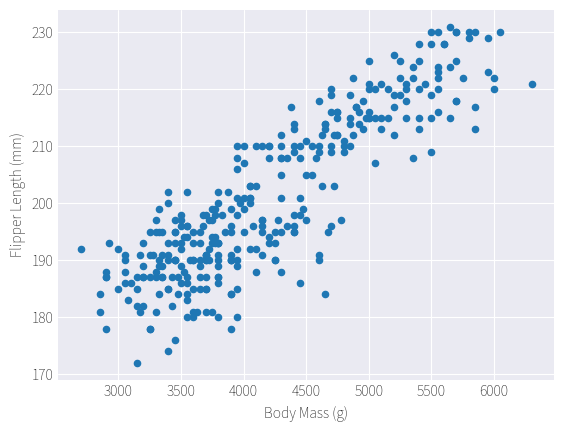

In [57]:
df.plot(kind='scatter', x='Body Mass (g)', y='Flipper Length (mm)') # 透過 plot 繪製散佈圖

array([[<Axes: title={'center': 'Body Mass (g)'}>]], dtype=object)

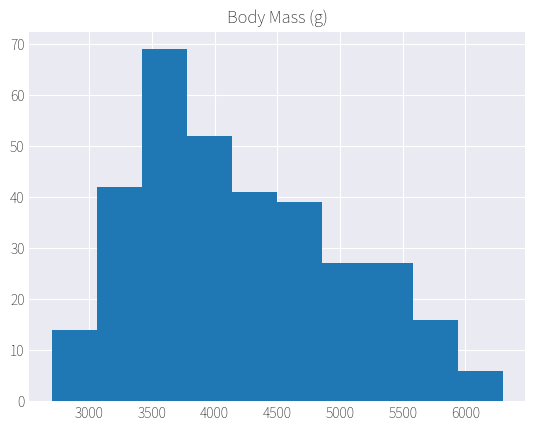

In [58]:
df.hist('Body Mass (g)') # 透過 hist 繪製直方圖

實際上，這些內建於資料表內的方法都是利用 `matplotlib` 這個套件達成的。因此我們也可以直接利用 `matplotlib` 繪製圖表，並加入更多客製化選項。

Text(0.5, 1.0, '體重與鰭長的散佈圖')

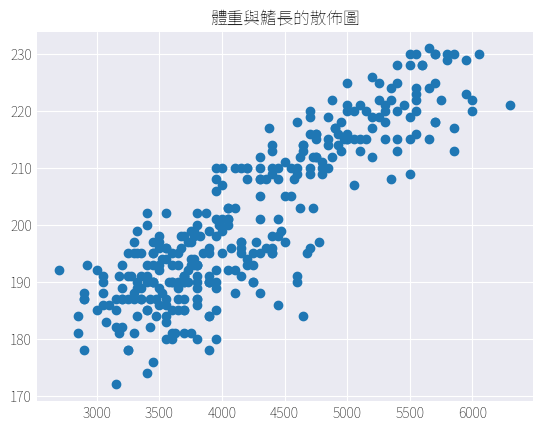

In [59]:
plt.scatter(df['Body Mass (g)'], df['Flipper Length (mm)']) # 透過 plt.scatter 繪製散佈圖
plt.title('體重與鰭長的散佈圖')

Text(0.5, 1.0, '體重的直方圖')

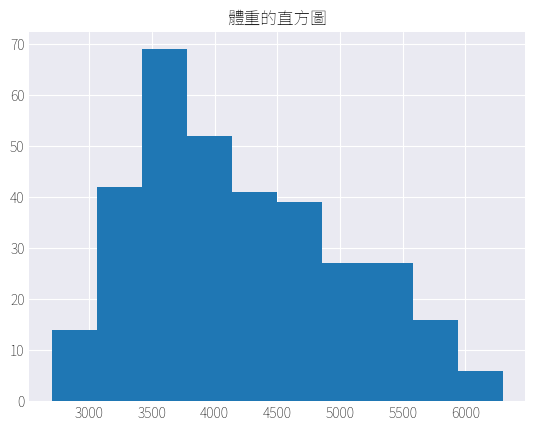

In [60]:
plt.hist(df['Body Mass (g)']) # 透過 plt.hist 繪製直方圖
plt.title('體重的直方圖')

`seaborn` 是另一個在 Python 上常用的視覺化套件。它包含各種統計常用的視覺化工具，並以簡單的語法繪製出精細的圖表，因此廣受好評。

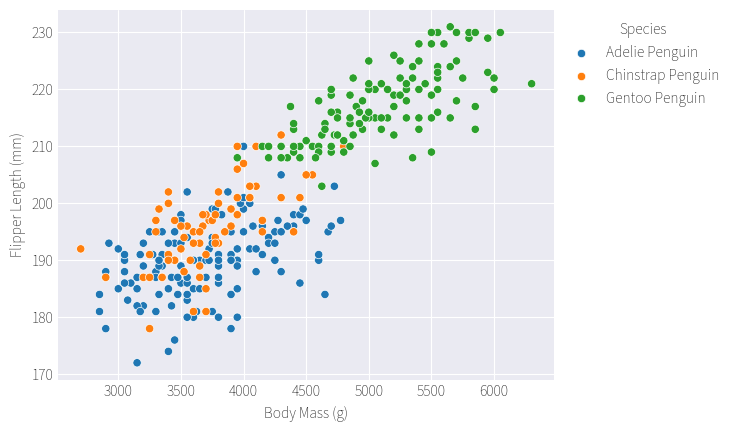

In [61]:
ax = sns.scatterplot(data=df, x='Body Mass (g)', y='Flipper Length (mm)', hue='Species') # 透過 seaborn 的 scatterplot 繪製散佈圖，並根據企鵝種類著色
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # 移動圖例至圖表外

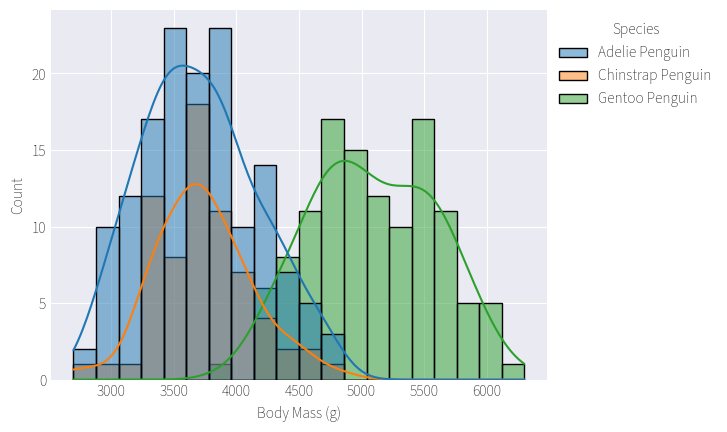

In [62]:
# 透過 seaborn 的 histplot 繪製直方圖，並根據企鵝種類著色，kde=True 代表顯示核密度估計，bins=20 代表分成 20 組
ax = sns.histplot(data=df, x='Body Mass (g)', hue='Species', kde=True, bins=20)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # 移動圖例至圖表外

([0, 1, 2],
 [Text(0, 0, 'Adelie Penguin'),
  Text(1, 0, 'Chinstrap Penguin'),
  Text(2, 0, 'Gentoo Penguin')])

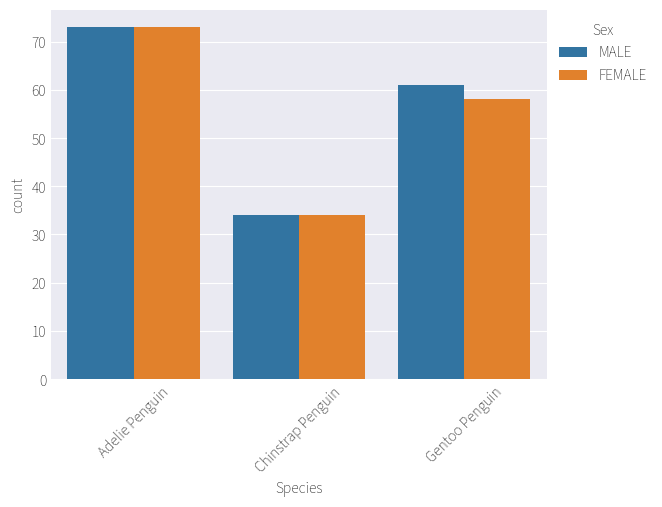

In [63]:
# 透過 seaborn 的 countplot 繪製企鵝種類計數圖，並根據性別著色
ax = sns.countplot(data=df, x='Species', hue='Sex')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) # 移動圖例至圖表外
plt.xticks(rotation=45) # 旋轉 x 軸標籤

([0, 1, 2],
 [Text(0, 0, 'Adelie Penguin'),
  Text(1, 0, 'Chinstrap Penguin'),
  Text(2, 0, 'Gentoo Penguin')])

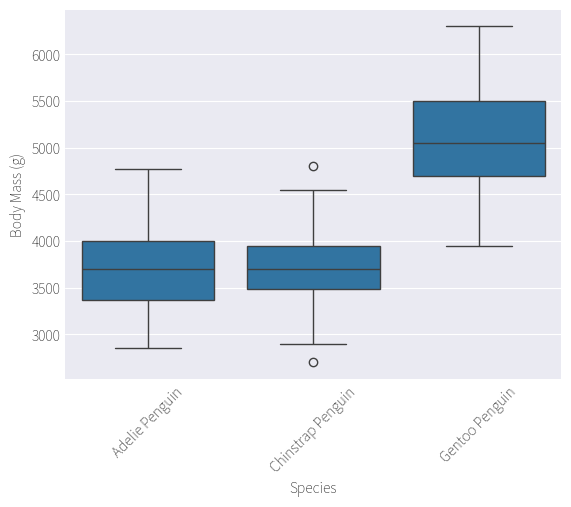

In [64]:
# 透過 seaborn 的 boxplot 繪製箱形圖，x 軸為企鵝種類，y 軸為體重
ax = sns.boxplot(data=df, x='Species', y='Body Mass (g)')
plt.xticks(rotation=45) # 旋轉 x 軸標籤

# 9. 資料匯出

當資料處理完成後，我們可以將其匯出，供其他人使用。

In [65]:
# duckdb.sql('COPY df TO final_penguins_duckdb.csv;') # 將資料輸出成 CSV 檔

In [66]:
# duckdb.sql("COPY df TO 'final_penguins_duckdb.xlsx' WITH (FORMAT GDAL, DRIVER 'xlsx');") # 將資料輸出成 Excel 檔

# 小試身手 2

任務 1: 讀入 `penguins_test2_1.csv` 與 `penguins_test2_2.csv` 資料集。

任務 2: 確認兩資料集的描述性統計與資料筆數、欄位數目，以及是否有重複值、遺失值。

任務 3: 將兩資料集依據 `ID` 欄位合併，僅合併兩資料集共有的 `ID` 部分。

任務 4: 計算不同島嶼上，不同企鵝種類下，不同性別的平均體重與鰭長中位數。

任務 5: 根據嘴喙長再根據嘴喙寬進行排序，其中嘴喙長請用降冪排序、嘴喙寬請用升冪排序。

任務 6: 繪製不同企鵝種類（以顏色區分）的嘴喙長與嘴喙寬的散布圖。

# 恭喜完成 Data Analysis 101 - DuckDB 的課程

透過這份教學，你已經了解基本的 `duckdb` 使用方法。如果想要學習更多的話，可以到 [duckdb 官網](https://duckdb.org/docs/) 學習更多指令的用法 :)